In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from collections import defaultdict

In [4]:
from convokit import Corpus, HyperConvo, TensorDecomposer, download, Classifier
from convokit import extract_feats_dict

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import svm

First we download the reddit corpus:

In [12]:
# corpus = Corpus(filename="convokit/thread_generator/fake-corpus-trajectory-40")
# corpus = Corpus(filename="convokit/thread_generator/annotated-fake-trajectory-40")
corpus = Corpus(download('reddit-corpus'))
# corpus = Corpus(filename="convokit/tensor_decomposer/experiments/reddit-trajectory-subset-annotated")

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus


In [13]:
corpus.print_summary_stats()

Number of Speakers: 521777
Number of Utterances: 2004262
Number of Conversations: 84979


### Data filtering

In [15]:
convo_ids = set(corpus.get_conversation_ids())

In [16]:
from convokit import Utterance, Speaker
filler_utts = [Utterance(id=cid, conversation_id=cid, speaker=Speaker(id='534rehwh3h')) for cid in convo_ids]

In [19]:
for utt in filler_utts:
    utt.timestamp = 0

In [17]:
corpus.add_utterances(filler_utts, warnings=True, with_checks=False)

In [18]:
full_convos = {c.id for c in corpus.iter_conversations() if c.check_integrity(verbose=False)}
len(full_convos)

84979

In [21]:
top_level_comment_ids = [utt.id for utt in corpus.iter_utterances() if utt.reply_to in convo_ids]
corpus = corpus.reindex_conversations(top_level_comment_ids)

In [22]:
corpus.print_summary_statsary_stats()

Number of Speakers: 521777
Number of Utterances: 2004262
Number of Conversations: 100000


In [24]:
import random
longest_path_ids = []
for convo in corpus.iter_conversations():
    longest_path = random.choice(convo.get_longest_paths())
    convo.meta['longest_path'] = len(longest_path)
    longest_path_ids.extend([utt.id for utt in longest_path])

In [26]:
longest_path_ids = set(longest_path_ids)

In [28]:
path_lengths = [convo.meta['longest_path'] for convo in corpus.iter_conversations()]

In [30]:
%matplotlib qt
import seaborn as sns
sns.countplot(path_lengths)

In [31]:
corpus = corpus.filter_utterances_by(lambda utt: utt.id in longest_path_ids and 
                                     utt.get_conversation().meta['longest_path'] >= 8)

In [32]:
corpus.print_summary_stats()

Number of Speakers: 129207
Number of Utterances: 508962
Number of Conversations: 45881


In [34]:
corpus.dump('reddit-focused-8', base_path='convokit/tensor_decomposer/experiments')

In [5]:
corpus = Corpus('convokit/tensor_decomposer/experiments/reddit-focused-8')

In [6]:
corpus.random_conversation().print_conversation_structure()

AnOddSmith
    JdPhoenix
        PG-13_Woodhouse
            JdPhoenix
                PG-13_Woodhouse
                    Ilyak1986
                        PG-13_Woodhouse
                            Ilyak1986
                                PG-13_Woodhouse


In [7]:
hyperconv_range = range(2, 7+1)

In [8]:
def multi_hyperconv_transform(corpus, hyperconv_range):
    hc_transformers = [HyperConvo(prefix_len=i, feat_name="hyperconvo-{}".format(i), invalid_val=-1) for i in hyperconv_range]
    for idx, hc in enumerate(list(reversed(hc_transformers))):
        print(hyperconv_range[-1]-idx)
        hc.transform(corpus)
multi_hyperconv_transform(corpus, hyperconv_range)
# corpus.dump('annotated-fake-trajectory-40', base_path="convokit/thread_generator")

7
6
5
4
3
2


In [9]:
grown = 0
thresh = 1.5
for convo in corpus.iter_conversations(lambda convo: convo.meta['longest_path'] >= 14):
    utts16 = convo.get_chronological_utterance_list()[:14]
    utts8 = utts16[:7]
    num_spkrs_8 = len(set(utt.speaker.id for utt in utts8))
    num_spkrs_16 = len(set(utt.speaker.id for utt in utts16))
    convo.meta['grown'] = (num_spkrs_16 / num_spkrs_8) >= thresh
    grown += (num_spkrs_16 / num_spkrs_8) >= thresh

In [10]:
len(list(corpus.iter_conversations(lambda convo: convo.meta['longest_path'] >= 14)))

7304

In [11]:
grown

730

## Classifier components

In [99]:
from convokit import Classifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold

model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])
kfold = KFold(n_splits=10, shuffle=True, random_state=2020)

pca = PCA(n_components=20, random_state=2020)

## Hyperconvo classifier

In [14]:
clf = Classifier(obj_type="conversation", pred_feats=['hyperconvo-7'], labeller=lambda convo: convo.meta['grown'],
                clf_feat_name='hyperconv-pred', clf_prob_feat_name='hyperconv-pred-score',  clf=model
                )

In [15]:
long14 = lambda convo: convo.meta['longest_path'] >= 14

In [16]:
res = clf.evaluate_with_cv(corpus, selector=long14)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [17]:
np.mean(res)

0.9000559759219151

In [18]:
clf.fit(corpus, selector=long14)

In [115]:
obj_id_to_feats = extract_feats_dict(corpus, "conversation", ["hyperconvo-7"], long14)
feats_df = pd.DataFrame.from_dict(obj_id_to_feats, orient='index').reindex(index = list(obj_id_to_feats))
X = csr_matrix(feats_df.values.astype('float64'))
y = np.array([convo.meta['grown'] for convo in corpus.iter_conversations(selector=long14)])

In [59]:
roc_scores = []

for train, test in kfold.split(X, y):
    model.fit(X[train], y[train])
    predict_proba = model.predict_proba(X[test])
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

0.5


### PCA

In [125]:
roc_scores = []
X = scale(X.toarray())
for train, test in kfold.split(X, y):
    
    model.fit(pca.fit_transform(X[train]), y[train])
    predict_proba = model.predict_proba(pca.transform(X[test]))
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


0.6232041817116005


## Averaged rep: HC-2 to HC-7

In [78]:
for convo in corpus.iter_conversations(long14):
    d = defaultdict(int)
    for idx in hyperconv_range:
        for k, v in convo.meta['hyperconvo-{}'.format(idx)].items():
            d[k] += v
    
    for k, v in d.items():
        d[k] = v / len(hyperconv_range)
    convo.meta['hyperconvo-avg'] = dict(d)

In [126]:
obj_id_to_feats = extract_feats_dict(corpus, "conversation", ["hyperconvo-avg"], long14)
feats_df = pd.DataFrame.from_dict(obj_id_to_feats, orient='index').reindex(index = list(obj_id_to_feats))
X = csr_matrix(feats_df.values.astype('float64'))
y = np.array([convo.meta['grown'] for convo in corpus.iter_conversations(selector=long14)])

In [127]:
roc_scores = []
X = scale(X.toarray())
for train, test in kfold.split(X, y):
    model.fit(X[train], y[train])
    predict_proba = model.predict_proba(X[test])
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


0.6234789264619349


### PCA

In [129]:
roc_scores = []
for train, test in kfold.split(X, y):
    model.fit(pca.fit_transform(X[train]), y[train])
    predict_proba = model.predict_proba(pca.transform(X[test]))
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

0.6237111883866623


## Concatenated rep: HC-2 to HC-7

In [94]:
for convo in corpus.iter_conversations(long14):
    d = dict()
    for idx in hyperconv_range:
        for k, v in convo.meta['hyperconvo-{}'.format(idx)].items():
            d[k+str(idx)] = v
    
    convo.meta['hyperconvo-concat'] = d

In [130]:
obj_id_to_feats = extract_feats_dict(corpus, "conversation", ["hyperconvo-concat"], long14)
feats_df = pd.DataFrame.from_dict(obj_id_to_feats, orient='index').reindex(index = list(obj_id_to_feats))
X = csr_matrix(feats_df.values.astype('float64'))
y = np.array([convo.meta['grown'] for convo in corpus.iter_conversations(selector=long14)])

In [131]:
roc_scores = []
X = scale(X.toarray())

for train, test in kfold.split(X, y):
    model.fit(pca.fit_transform(X[train]), y[train])
    predict_proba = model.predict_proba(pca.transform(X[test]))
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


0.6172415691895714


## Rank-20 non-negative TCA

In [101]:
from sklearn.preprocessing import scale
def scale_by_comment_idx(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[0]):
        tensor[i, :, :] = scale(tensor[i, :, :])
    return tensor

In [102]:
td = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 7)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=20, tensor_func='tensortools-ncp-bcd', normalize_func=scale_by_comment_idx
                     )

In [103]:
td.fit(corpus, selector=lambda convo: convo.meta['longest_path'] >= 14)

Constructing tensor...Done.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Py

Decomposing tensor...NCP_BCD: iteration 1, objective 0.9752328449871601, improvement inf.
NCP_BCD: iteration 2, objective 0.9482366291273642, improvement 0.026996215859795947.
NCP_BCD: iteration 3, objective 0.9281696790812498, improvement 0.020066950046114362.
NCP_BCD: iteration 4, objective 0.9108438533747785, improvement 0.017325825706471343.
NCP_BCD: iteration 5, objective 0.8897067825668089, improvement 0.02113707080796956.
NCP_BCD: iteration 6, objective 0.8686007327871634, improvement 0.021106049779645475.
NCP_BCD: iteration 7, objective 0.8521243708926308, improvement 0.01647636189453261.
NCP_BCD: iteration 8, objective 0.8408816883387459, improvement 0.011242682553884942.
NCP_BCD: iteration 9, objective 0.8315439231981193, improvement 0.009337765140626564.
NCP_BCD: iteration 10, objective 0.8233344429122232, improvement 0.008209480285896076.
NCP_BCD: iteration 11, objective 0.8167002777792959, improvement 0.006634165132927361.
NCP_BCD: iteration 12, objective 0.812793852748975

In [104]:
td.transform(corpus, selector=lambda convo: convo.meta['longest_path'] >= 14)

In [105]:
from convokit import BoWClassifier

In [106]:
clf_tensor = BoWClassifier(obj_type="conversation", vector_name='tensor_factor', labeller=lambda convo: convo.meta['grown'],
                clf_feat_name='tensor-pred', clf_prob_feat_name='tensor-pred-score', clf=model
                )

In [107]:
from sklearn.model_selection import KFold

In [108]:
res = clf_tensor.evaluate_with_cv(corpus, selector=lambda convo: convo.meta['longest_path'] >= 14, cv=KFold(n_splits=5, shuffle=True))

Using corpus objects...

Running a cross-validated evaluation...
Done.


In [109]:
np.mean(res)

0.9000543819676896

In [38]:
clf_tensor.fit(corpus, selector=long14)

In [110]:
from scipy.sparse import vstack, issparse
X = []
y = []
for obj in corpus.iter_objs('conversation', long14):
    X.append(obj.meta['tensor_factor'])
    y.append(obj.meta['grown'])
if issparse(X[0]): # for csr_matrix
    X = vstack(X)
else: # for non-compressed numpy arrays
    X = np.vstack(X)
y = np.array(y)

In [113]:
roc_scores = []

for train, test in kfold.split(X, y):
    model.fit(X[train], y[train])
    predict_proba = model.predict_proba(X[test])
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

0.615434769825202


## Combined feature sets

In [132]:
obj_id_to_feats = extract_feats_dict(corpus, "conversation", ["hyperconvo-7"], long14)
feats_df = pd.DataFrame.from_dict(obj_id_to_feats, orient='index').reindex(index = list(obj_id_to_feats))
X_hc7 = csr_matrix(feats_df.values.astype('float64'))

In [137]:
obj_id_to_feats = extract_feats_dict(corpus, "conversation", ["hyperconvo-avg"], long14)
feats_df = pd.DataFrame.from_dict(obj_id_to_feats, orient='index').reindex(index = list(obj_id_to_feats))
X_hc_avg = csr_matrix(feats_df.values.astype('float64'))

In [136]:
obj_id_to_feats = extract_feats_dict(corpus, "conversation", ["hyperconvo-concat"], long14)
feats_df = pd.DataFrame.from_dict(obj_id_to_feats, orient='index').reindex(index = list(obj_id_to_feats))
X_hc_concat = csr_matrix(feats_df.values.astype('float64'))

In [141]:
from scipy.sparse import vstack, issparse
X_tensor = []
y = []
for obj in corpus.iter_objs('conversation', long14):
    X_tensor.append(obj.meta['tensor_factor'])
if issparse(X[0]): # for csr_matrix
    X_tensor = vstack(X_tensor)
else: # for non-compressed numpy arrays
    X_tensor = np.vstack(X_tensor)

In [146]:
y = np.array([convo.meta['grown'] for convo in corpus.iter_conversations(long14)])

### Hyperconvo-7 (PCA) + TCA (rank 20)

In [164]:
roc_scores = []
X = scale(X_hc7.toarray())

for train, test in kfold.split(X, y):
    
    X_combi_train = np.hstack((pca.fit_transform(X[train]), X_tensor[train])) 
    model.fit(X_combi_train, y[train])
    X_combi_test = np.hstack((pca.fit_transform(X[test]), X_tensor[test]))
    predict_proba = model.predict_proba(X_combi_test)
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


0.5745332287375828


### HC-Avg (PCA) + TCA

In [194]:
roc_scores = []
# X = scale(X_hc_avg.toarray())
X = X_hc_avg.toarray()

for train, test in kfold.split(X, y):
    
    X_combi_train = np.hstack((pca.fit_transform(X[train]), X_tensor[train])) 
    model.fit(X_combi_train, y[train])
    X_combi_test = np.hstack((pca.fit_transform(X[test]), X_tensor[test]))
    predict_proba = model.predict_proba(X_combi_test)
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

0.509109467616744


### HC-Concat (PCA) + TCA

In [168]:
X_hc_concat.toarray()[0]

array([ 1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.5       ,  1.        ,  0.5       ,  0.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.5       ,
        0.5       ,  1.        ,  1.        ,  0.5       ,  0.5       ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.5       ,  0.5       ,
        1.        ,  1.        ,  0.5       ,  0.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [193]:
roc_scores = []
# X = scale(X_hc_concat.toarray())
X = X_hc_concat.toarray()
for train, test in kfold.split(X, y):
    X_combi_train = np.hstack((pca.fit_transform(X[train]), X_tensor[train])) 
    model.fit(X_combi_train, y[train])
    X_combi_test = np.hstack((pca.fit_transform(X[test]), X_tensor[test]))
    predict_proba = model.predict_proba(X_combi_test)
    roc_scores.append(roc_auc_score(y_true=y[test], y_score=[x[1] for x in predict_proba]))

print(np.mean(roc_scores))

0.507870116498549


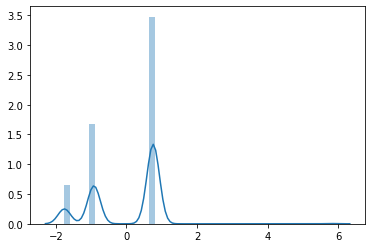

In [188]:
import seaborn as sns

sns.distplot(X[:, 514])

In [190]:
np.sum(np.abs(X[:,514]))

6771.20878630641

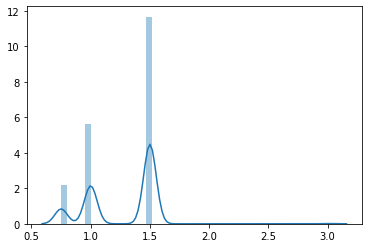

In [192]:
sns.distplot(X_hc_concat.toarray()[:, 514])